# Assessment 3 - A new tool for detecting prostate cancers
### Authors: Jeffrey Mills (28083938), 

**Required Libraries -** The following R libraries are referenced in this notebook
* glmnet
* ROCR
---
### Table of Contents

[1. Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)

[2. EDA Report](#2.-EDA-Report)

---

In [465]:
# disable scientific notation and set to 4 digits
options(scipen=999)
options(digits=4)
# set the default plot size
options(repr.plot.width = 6)
options(repr.plot.height = 4)

In [466]:
# install packages ggplot2 for more fancier plots and graphs
# and psych for a more comprehensive stats package
# only install if not already installed
list.of.packages <- c("ggplot2", "psych", "ROCR", "leaps", "glmnet", "caret", "xgboost", "Matrix", "Ckmeans.1d.dp")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos="http://cran.uk.r-project.org")

In [467]:
# import ggplot for some of the more fancier plots if needed
library("ggplot2")
# import more comprehensive summary stats package
library(psych)
# import ROCR for easier model performance checking
library("ROCR")

library("caret")

library("xgboost")
library("Matrix")
library("Ckmeans.1d.dp")

In [468]:
# import local utilities.R file
source("./utilities.r")

## 1. Exploratory Data Analysis

In [469]:
prostate <- read.csv("./prostate.csv")

In [470]:
# Before we do anything, dedicate 20% of our data to an unseen Test set.

# 20% of the sample size
smp_size <- floor(0.8 * nrow(prostate))

# set the seed to make our partition reproductible
set.seed(123)
train_ind <- sample(seq_len(nrow(prostate)), size = smp_size)

train <- prostate[train_ind, ]
test <- prostate[-train_ind, ]

In [471]:
# Check the head of the dataframe
head(train)

,ID,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
863,863,5,8,10,9,2,2,8,6,2,3,0
2365,2365,4,4,2,4,4,1,3,7,3,9,0
1227,1227,7,4,9,2,4,2,3,9,9,8,0
2647,2647,5,5,7,2,4,1,8,10,1,7,3
2818,2818,10,1,2,5,7,2,8,5,9,5,1
137,137,8,1,2,10,10,2,2,3,1,5,0


In [472]:
# Check structure of the datatypes
str(train)

'data.frame':	2400 obs. of  12 variables:
 $ ID    : int  863 2365 1227 2647 2818 137 1582 2672 1650 1366 ...
 $ ATT1  : int  5 4 7 5 10 8 7 2 2 5 ...
 $ ATT2  : int  8 4 4 5 1 1 1 10 1 4 ...
 $ ATT3  : int  10 2 9 7 2 2 5 5 6 10 ...
 $ ATT4  : int  9 4 2 2 5 10 4 8 2 7 ...
 $ ATT5  : int  2 4 4 4 7 10 8 5 8 10 ...
 $ ATT6  : int  2 1 2 1 2 2 1 4 2 10 ...
 $ ATT7  : int  8 3 3 8 8 2 9 2 3 3 ...
 $ ATT8  : int  6 7 9 10 5 3 2 6 4 8 ...
 $ ATT9  : int  2 3 9 1 9 1 6 1 1 10 ...
 $ ATT10 : int  3 9 8 7 5 5 7 3 4 2 ...
 $ Result: int  0 0 0 3 1 0 0 2 2 1 ...


We can drop the ID column as it adds no benefit to our modelling

In [473]:
train$ID <- NULL

Given that we know the **Result** variable is our target variable which represents one of 4 stages of the cancer (0 for curable, and 1 for tumour stage, 2 for node stage and 3 for incurable cancers) - this should be represented as a factor. 

In [474]:
train$Result <- as.factor(train$Result) 

In [475]:
# Let's check for incomplete observations
nrow(train[complete.cases(train),])

[1] 2400

In [476]:
# Check the proportions of each factor within the Result variable
w <- table(train$Result)
w


  0   1   2   3 
868 876 495 161 

In [477]:
round(describe(train), 3)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
ATT1,1.000,2400.000,5.835,2.651,6.000,5.793,2.965,2.000,10.000,8.000,0.098,-1.160,0.054
ATT2,2.000,2400.000,4.510,2.736,4.000,4.327,2.965,1.000,10.000,9.000,0.401,-0.972,0.056
ATT3,3.000,2400.000,5.865,2.675,6.000,5.831,2.965,2.000,10.000,8.000,0.090,-1.189,0.055
ATT4,4.000,2400.000,5.807,2.630,6.000,5.759,2.965,2.000,10.000,8.000,0.090,-1.154,0.054
ATT5,5.000,2400.000,5.767,2.631,6.000,5.708,2.965,2.000,10.000,8.000,0.111,-1.144,0.054
ATT6,6.000,2400.000,4.450,2.699,4.000,4.264,2.965,1.000,10.000,9.000,0.433,-0.947,0.055
ATT7,7.000,2400.000,4.474,2.739,4.000,4.290,2.965,1.000,10.000,9.000,0.399,-1.026,0.056
ATT8,8.000,2400.000,4.499,2.729,4.000,4.317,2.965,1.000,10.000,9.000,0.386,-0.978,0.056
ATT9,9.000,2400.000,4.484,2.688,4.000,4.299,2.965,1.000,10.000,9.000,0.412,-0.918,0.055
ATT10,10.000,2400.000,4.451,2.689,4.000,4.263,2.965,1.000,10.000,9.000,0.412,-0.935,0.055


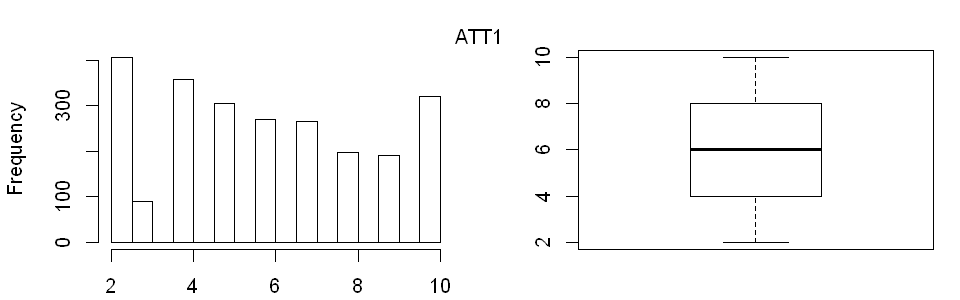

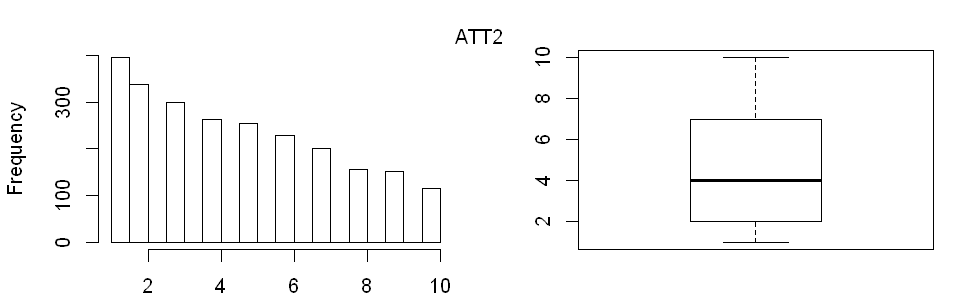

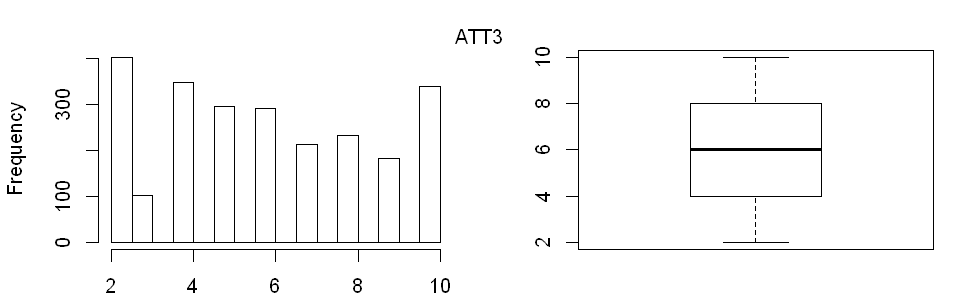

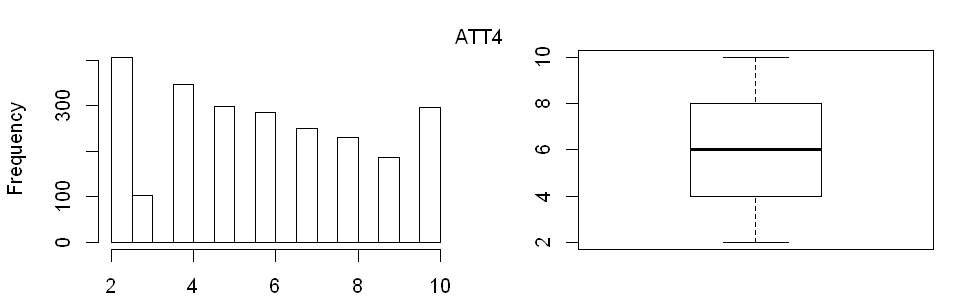

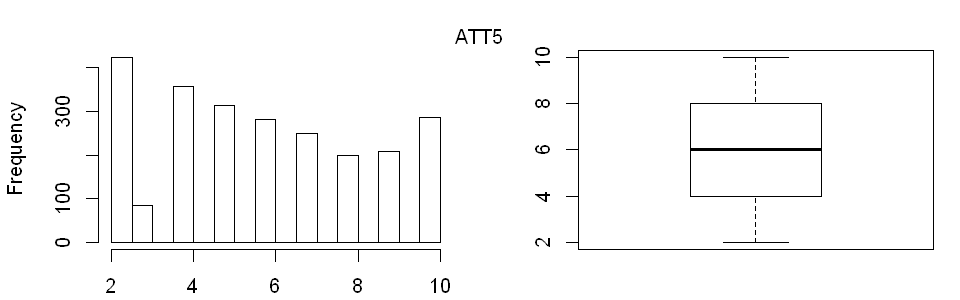

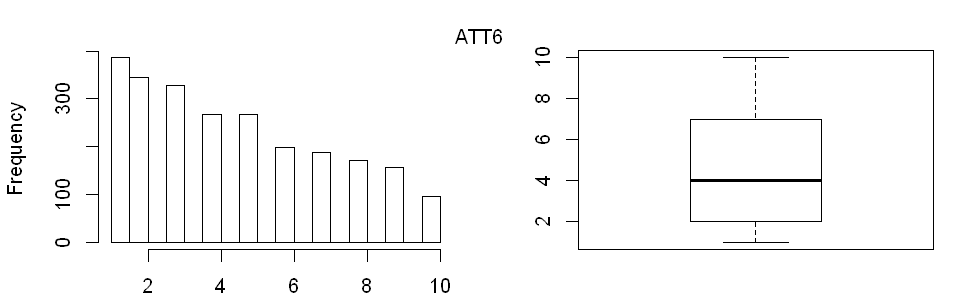

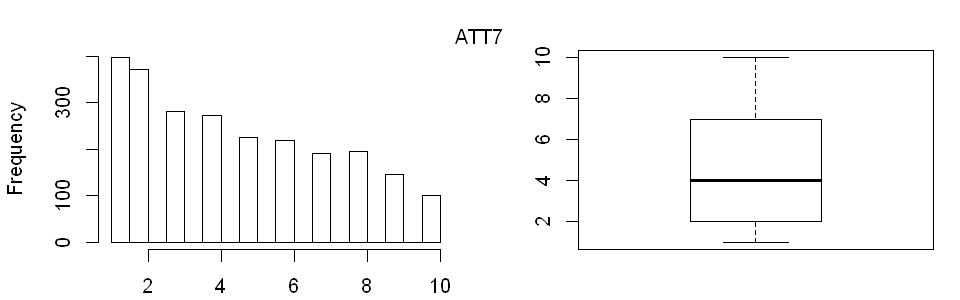

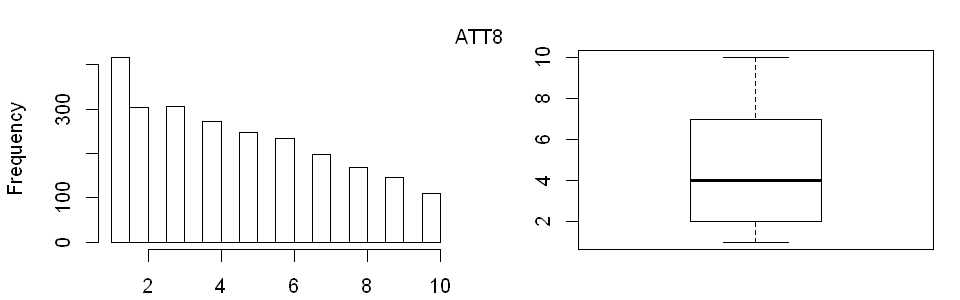

ERROR: Error in hist.default(train[[i]], xlab = NULL, main = NULL): 'x' must be numeric


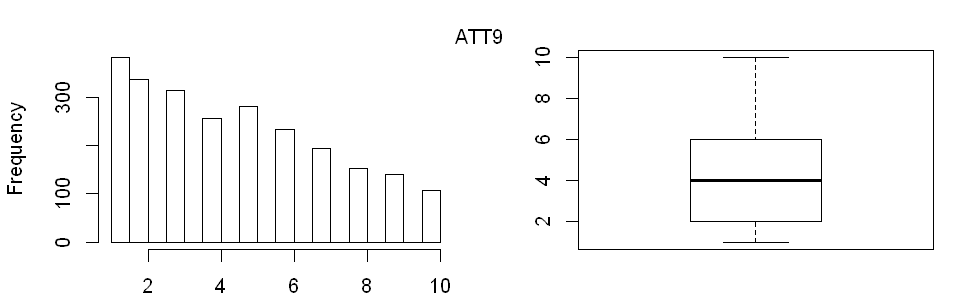

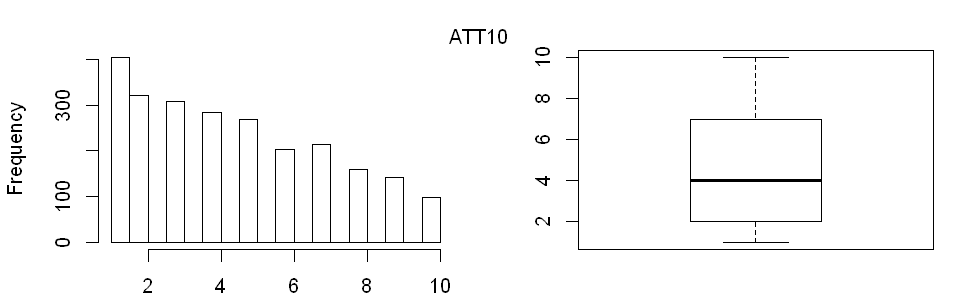

In [478]:
oldpar <- par() #this records all the default settings
par(mfrow=c(1,2)) # this makes to plots in one row
par(mar=c(2.1,4.1,2.1,1.1)) #BLTR
options(repr.plot.width=8, repr.plot.height=2.5)
for (i in names(train)) {
    if (i != "quality") {
        hist(train[[i]],xlab=NULL,main=NULL)
        boxplot(train[[i]])
        mtext(i,side=3,line=-2, outer=TRUE)
    }
}
suppressWarnings( par(oldpar)) # Restore settings

In [ ]:
options(repr.plot.width = 3)
options(repr.plot.height = 2)
ggplot(train, aes(x = Result, y = ATT1)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT2)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT3)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT4)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT5)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT6)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT7)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT8)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT9)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT10)) + geom_boxplot()
options(repr.plot.width = 6)
options(repr.plot.height = 4)

In [ ]:
ggplot(aes(x=ATT5, y=ATT2, color=Result),  #by setting color=color, ggplot automatically draw in different colors
       data=train) + geom_point(stat='summary', fun.y=median)

## 2. EDA Report

Perform an EDA, and prepare a summary of your findings. The summary should be less than 300 words. You need to emphasise on the aspects of the EDA that guide you in choosing a particular model or algorithm for your classifier. If you want to include any chart in your notebook, there should be something you have learnt and you are going to use it in your model selection. Please provide a short explanation on what you have learnt just after the cell. In addition, types of variables, the dimension of the data, and any correlation between variables are very important. Also, you might need to look at some distribution of your variables to get some insights.

## 3. XGBoost

In [490]:
# perform down sampling to obtain even amount of classes
xg_train <- Udf.Utilities.UpSample(train)
xg_test <- test

In [491]:
# Check the proportions of each factor within the Result variable
w <- table(xg_train$Result)
w


  0   1   2   3 
876 876 876 876 

In [492]:
# store the actuals for future comparison
actual <- test$Result

In [493]:
# set the Result to a numeric range from 0 - 3
xg_train.y <- as.numeric(xg_train$Result)-1
xg_test.y <- as.numeric(test$Result)-1

In [494]:
# convert to matrix for boosting method
xg_train <- sparse.model.matrix(Result ~ ., data = xg_train)
dtrain <- xgb.DMatrix(data=xg_train, label=xg_train.y)

In [495]:
xg_test <- sparse.model.matrix(Result ~ ., data = xg_test)
dtest <- xgb.DMatrix(data=xg_test, label=xg_test.y)

In [496]:
# cross validate to select optimal value for number of rounds
n_rounds.cv <- 500
params <- list(booster = "gbtree", objective = "multi:softmax",
               num_class = 4, eval_metric = 'merror',
               max_depth = 6, eta = 0.1,
               colsample_bytree = 0.9, subsample = 0.9)

bst.cv <- xgb.cv(params, dtrain, n_rounds.cv, nfold = 10, metrics = {'merror'},
                 print.every.n = 20, prediction = TRUE)

[0]	train-merror:0.488362+0.012162	test-merror:0.605866+0.021437
[20]	train-merror:0.171646+0.008200	test-merror:0.454660+0.019618
[40]	train-merror:0.101280+0.005373	test-merror:0.424674+0.017310
[60]	train-merror:0.061802+0.004674	test-merror:0.402711+0.020407
[80]	train-merror:0.038496+0.003929	test-merror:0.385304+0.020115
[100]	train-merror:0.022038+0.001826	test-merror:0.382162+0.022435
[120]	train-merror:0.012620+0.001365	test-merror:0.376458+0.020832
[140]	train-merror:0.007103+0.001617	test-merror:0.371029+0.017578
[160]	train-merror:0.003995+0.000993	test-merror:0.367041+0.017106
[180]	train-merror:0.002252+0.000676	test-merror:0.366189+0.022518
[200]	train-merror:0.001364+0.000819	test-merror:0.362756+0.018848
[220]	train-merror:0.000571+0.000417	test-merror:0.364765+0.018823
[240]	train-merror:0.000190+0.000306	test-merror:0.365053+0.019148
[260]	train-merror:0.000063+0.000134	test-merror:0.361338+0.021556
[280]	train-merror:0.000000+0.000000	test-merror:0.363331+0.019115
[

In [486]:
n_rounds.train <- which.min(bst.cv$dt[, test.merror.mean])
n_rounds.train

[1] 177

In [497]:
# create the model
bst <- xgb.train(   params              = param, 
                    data                = dtrain, 
                    nrounds             = n_rounds.train, 
                    verbose             = 1,
                    watchlist           = watchlist,
                    maximize            = FALSE
)

[0]	xgbTrain-merror:0.251553
[1]	xgbTrain-merror:0.178571
[2]	xgbTrain-merror:0.133540
[3]	xgbTrain-merror:0.085404
[4]	xgbTrain-merror:0.065217
[5]	xgbTrain-merror:0.055901
[6]	xgbTrain-merror:0.048137
[7]	xgbTrain-merror:0.038820
[8]	xgbTrain-merror:0.032609
[9]	xgbTrain-merror:0.018634
[10]	xgbTrain-merror:0.015528
[11]	xgbTrain-merror:0.017081
[12]	xgbTrain-merror:0.015528
[13]	xgbTrain-merror:0.013975
[14]	xgbTrain-merror:0.010870
[15]	xgbTrain-merror:0.007764
[16]	xgbTrain-merror:0.007764
[17]	xgbTrain-merror:0.004658
[18]	xgbTrain-merror:0.004658
[19]	xgbTrain-merror:0.003106
[20]	xgbTrain-merror:0.001553
[21]	xgbTrain-merror:0.001553
[22]	xgbTrain-merror:0.000000
[23]	xgbTrain-merror:0.001553
[24]	xgbTrain-merror:0.000000
[25]	xgbTrain-merror:0.001553
[26]	xgbTrain-merror:0.000000
[27]	xgbTrain-merror:0.000000
[28]	xgbTrain-merror:0.000000
[29]	xgbTrain-merror:0.000000
[30]	xgbTrain-merror:0.000000
[31]	xgbTrain-merror:0.000000
[32]	xgbTrain-merror:0.000000
[33]	xgbTrain-merror

In [498]:
# generate predictions from model
pred <- predict(bst, xg_test);

In [500]:
confusionMatrix(pred, actual)

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0  89  84  59  15
         1 102  97  66  18
         2  20  20  19   2
         3   3   3   3   0

Overall Statistics
                                          
               Accuracy : 0.342           
                 95% CI : (0.304, 0.381)  
    No Information Rate : 0.357           
    P-Value [Acc > NIR] : 0.791           
                                          
                  Kappa : 0.013           
 Mcnemar's Test P-Value : 0.00000000000542

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.416    0.475   0.1293   0.0000
Specificity             0.591    0.530   0.9073   0.9841
Pos Pred Value          0.360    0.343   0.3115   0.0000
Neg Pred Value          0.646    0.662   0.7625   0.9408
Prevalence              0.357    0.340   0.2450   0.0583
Detection Rate          0.148    0.162   0.0317   0.0000
Detection Prevalence    0.

In [ ]:
feature.importance <- xgb.importance(dimnames(xg_train)[[2]], model = bst)
head(feature.importance)

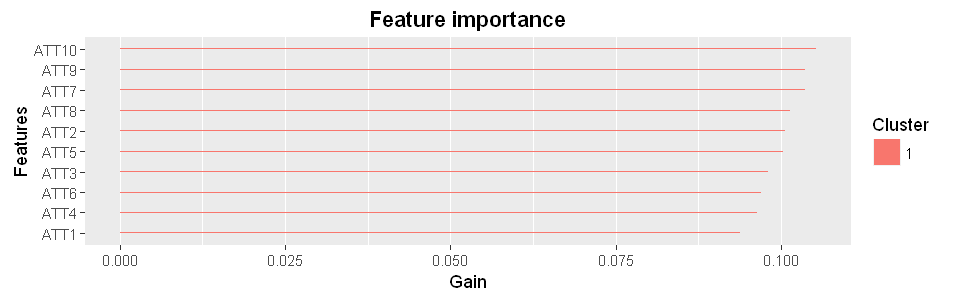

In [464]:
xgb.plot.importance(feature.importance)